In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy

You should consider upgrading via the '/media/programming/projects/machineLearning/ML/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from IPython import display
import time
from IPython.display import Image
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio
import math
import glob
import PIL
import PIL.Image
from sklearn.model_selection import train_test_split
import keras_tuner as kt

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist, fashion_mnist
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-06-18 10:48:51.635550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 10:48:51.656970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 10:48:51.657112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 10:48:51.657833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.1


In [5]:
def loadDataFashion():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    TrainX = np.concatenate((train_images, test_images))
    # Normalize byte [0,255] -> [0,1]
    TrainX = (TrainX / 255.0)

    return TrainX

    #
def loadMNIST():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    # Normalize byte [0,255] -> [0,1]
    train_X = train_X / 255.0
    test_X = test_X / 255.0

    return np.concatenate((train_X, test_X))


In [6]:
EPOCHS=64
BATCH_SIZE=128

In [7]:


fashionX = loadDataFashion()
MnistX = loadMNIST()

trainX = np.concatenate((fashionX, MnistX)).astype(dtype='float16')
#trainX, trainXValidation = train_test_split(trainX, test_size=0.20, random_state=42)


## Presenting Example Data

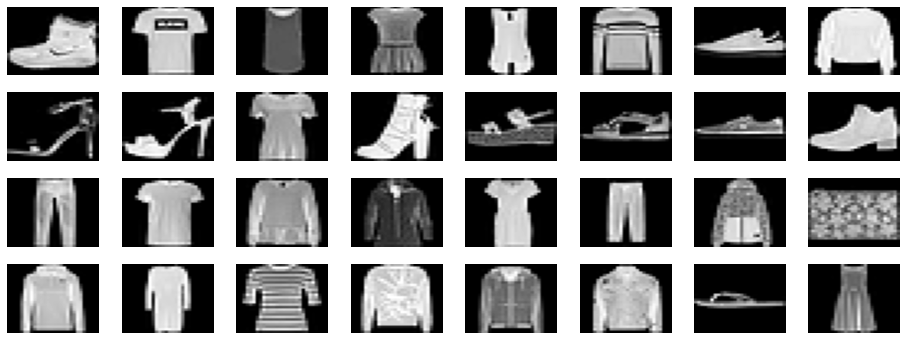

In [8]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8
for index, image in enumerate(trainX[0:nrImage]):
    plt.subplot(4, 8, (index + 1))

    plt.imshow(X=((image + 1.0) / 2.0).astype(dtype='float32'), cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


# Create Compression Model

In [9]:
def generate_cnn_builder(hp, image_size):
    latent_dim = 64

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
    kernel_activation = hp.Choice('kernel_activation',['relu', 'sigmoid', 'softmax', 'tanh'])

    latent_space = hp.Int(
        'latent_space', min_value=16, max_value=128, step=16)
    number_layers = hp.Int(
        'number_layers', min_value=1, max_value=4, step=1)

    # hp_max_pooling_size_l0 = hp.Int(
    #     'max_pooling_l0', min_value=1, max_value=3, step=1)
    # hp_max_pooling_size_l1 = hp.Int(
    #     'max_pooling_l1', min_value=1, max_value=2, step=1)

    class Autoencoder(keras.Model):
        def __init__(self,**kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            layers = [layers.Dense(64, activation=kernel_activation) for i in range(0, number_layers)]
            self.encoder = tf.keras.Sequential([
                layers.Flatten(),

                layers.Dense(latent_space, activation=kernel_activation, kernel_initializer=kernel_init),
            ])
            self.decoder = tf.keras.Sequential([

                layers.Dense(64, activation=kernel_activation), 
                layers.Dense(np.prod(image_size), activation=kernel_activation, dtype='float32', kernel_initializer=kernel_init),
                layers.Reshape(image_size)
            ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

        def getEncoder(self):
            return self.encoder
        def getDecoder(self):
            return self.decoder

        def compile(self,**kwargs):
            super(Autoencoder, self).compile(**kwargs)

    autoencoder = Autoencoder()
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    autoencoder.compile(optimizer=hp_optimizer, loss='mse', metrics=['accuracy'])

    return autoencoder


## Hyperparameter

In [10]:

image_shape = trainX[0].shape
print('X_train: ' + str(image_shape))


def model_builder(hp):
    model = generate_cnn_builder(hp, image_shape)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='cache',
                     project_name=str.format('MNIST AutoEncoder - {0}', "Compression"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tuner.search(trainX, trainX,epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

autoencoder_model = tuner.hypermodel.build(best_hps)

Trial 30 Complete [00h 00m 33s]
accuracy: 0.3823290765285492

Best accuracy So Far: 0.3823290765285492
Total elapsed time: 00h 06m 14s
INFO:tensorflow:Oracle triggered exit


## Train Finalize Model

In [11]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage)
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 2 * 2))
    for i in range(nrElements):
        trainImage = image

        ax = plt.subplot(2, maxNumImages, i + 1)
        plt.imshow((batchImage[i].astype(dtype='float32')), cmap='gray')
        plt.axis("off")

        ax = plt.subplot(2, maxNumImages, maxNumImages + i + 1)
        plt.imshow((output[i].astype(dtype='float32')), cmap='gray')
        plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData[0:20]

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("MNISTCompression{0}.png".format(epoch))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig("MNISTCompressionBig{0}.png".format(epoch))


In [12]:

checkpoint_path = "checkpoints/mnist_autoencoder_compression/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=autoencoder_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    autoencoder_model.load_weights(checkpoint_path)

model_history = autoencoder_model.fit(trainX, trainX,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_split=0.1, shuffle=True,
                          verbose=1, callbacks=[cp_callback, save_images(trainX)])

autoencoder_model.save_weights(checkpoint_path)


Epoch 1/64
985/985 [==============================] - 3s 3ms/step - loss: 0.0509 - accuracy: 0.2093 - val_loss: 0.0317 - val_accuracy: 0.4243
Epoch 2/64
985/985 [==============================] - 3s 3ms/step - loss: 0.0350 - accuracy: 0.3072 - val_loss: 0.0255 - val_accuracy: 0.4826
Epoch 3/64
985/985 [==============================] - 2s 2ms/step - loss: 0.0320 - accuracy: 0.3255 - val_loss: 0.0229 - val_accuracy: 0.4868
Epoch 4/64
985/985 [==============================] - 3s 3ms/step - loss: 0.0304 - accuracy: 0.3359 - val_loss: 0.0219 - val_accuracy: 0.4899
Epoch 5/64
985/985 [==============================] - 2s 2ms/step - loss: 0.0292 - accuracy: 0.3415 - val_loss: 0.0209 - val_accuracy: 0.5172
Epoch 6/64
985/985 [==============================] - 2s 2ms/step - loss: 0.0282 - accuracy: 0.3468 - val_loss: 0.0195 - val_accuracy: 0.5044
Epoch 7/64
985/985 [==============================] - 3s 3ms/step - loss: 0.0271 - accuracy: 0.3520 - val_loss: 0.0199 - val_accuracy: 0.5127
Epoch 

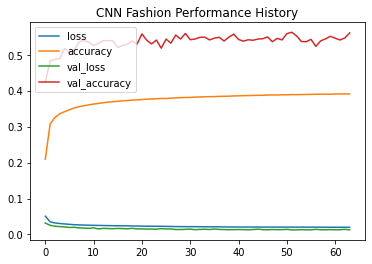

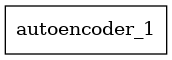

<Figure size 432x288 with 0 Axes>

In [13]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Fashion"))

tf.keras.utils.plot_model(
    autoencoder_model, to_file=str.format('cnn_{0}_model.png', "Fashion"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
